# Predicting Heart Disease

Link to Competittion: https://www.kaggle.com/competitions/playground-series-s6e2/overview

## Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10, 5)

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc, accuracy_score, mean_squared_error, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.tree import plot_tree

from common import *

In [2]:
from platform import python_version
print('python: ', python_version())
print('pandas: ', pd.__version__)
print('numpy: ', np.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn: ', sns.__version__)
import sklearn
print('sklearn: ', sklearn.__version__)
print('xgboost: ', xgb.__version__)
print('LightGBM: ', lgb.__version__)

python:  3.13.11
pandas:  2.3.3
numpy:  2.3.5
matplotlib:  3.10.8
seaborn:  0.13.2
sklearn:  1.8.0
xgboost:  3.1.3
LightGBM:  4.6.0


## Load data

In [3]:
orig_train_df = pd.read_csv('archive/train.csv')
orig_test_df = pd.read_csv('archive/test.csv')

## Call the pipeline

In [4]:
train_df = (orig_train_df
          .pipe(copy_data)
          .pipe(clean_data)
          # .pipe(remove_outliers)
          # .pipe(remove_duplicates)
          .pipe(make_new_features)
          # .pipe(encode_all_the_things)
          # .pipe(fill_nas)
           )

In [5]:
test_df = (orig_test_df
          .pipe(copy_data)
          .pipe(clean_data)
          # .pipe(remove_outliers)
          # .pipe(remove_duplicates)
          .pipe(make_new_features)
          # .pipe(encode_all_the_things)
          # .pipe(fill_nas)
           )

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   age                      630000 non-null  int64  
 1   sex                      630000 non-null  int64  
 2   chest_pain_type          630000 non-null  int64  
 3   bp                       630000 non-null  int64  
 4   cholesterol              630000 non-null  int64  
 5   fbs_over_120             630000 non-null  int64  
 6   ekg_results              630000 non-null  int64  
 7   max_hr                   630000 non-null  int64  
 8   exercise_angina          630000 non-null  int64  
 9   st_depression            630000 non-null  float64
 10  slope_of_st              630000 non-null  int64  
 11  number_of_vessels_fluro  630000 non-null  int64  
 12  thallium                 630000 non-null  int64  
 13  heart_disease            630000 non-null  int64  
dtypes: f

## Choose target and features

In [7]:
target = get_target()

In [8]:
features = get_features(train_df)

In [9]:
categorical_features = []

In [10]:
numerical_features = [f for f in features if f not in categorical_features]

In [11]:
categorical_features

[]

In [12]:
numerical_features

['age',
 'sex',
 'chest_pain_type',
 'bp',
 'cholesterol',
 'fbs_over_120',
 'ekg_results',
 'max_hr',
 'exercise_angina',
 'st_depression',
 'slope_of_st',
 'number_of_vessels_fluro',
 'thallium']

## Encoding

In [13]:
X_train = train_df[features].copy()
y_train = train_df[target]

X_test = test_df[features].copy()

## XGBoost

In [14]:
xgb_model = XGBClassifier()

In [15]:
xgb = xgb_model.fit(X_train, y_train)

In [16]:
preds = xgb_model.predict(X_train)

In [17]:
print(f"{xgb.score(X_train, y_train):.5f}")

0.89198


In [18]:
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=10)

In [19]:
print(f"CV mean: {np.mean(xgb_scores):.5f}")

CV mean: 0.88820


In [20]:
print(f"ROC AUC: {roc_auc_score(y_train, preds):.5f}")

ROC AUC: 0.89007


In [21]:
importance_df = pd.DataFrame({'Features': xgb_model.feature_names_in_, 'Importance': xgb_model.feature_importances_})

In [22]:
importance_df.sort_values(by='Importance', ascending=False)

,Features,Importance
12,thallium,0.630840
2,chest_pain_type,0.117627
11,number_of_vessels_fluro,0.057834
8,exercise_angina,0.055951
10,slope_of_st,0.051514
1,sex,0.030380
7,max_hr,0.017243
9,st_depression,0.016991
6,ekg_results,0.013165
0,age,0.004952


<Axes: xlabel='Importance', ylabel='Features'>

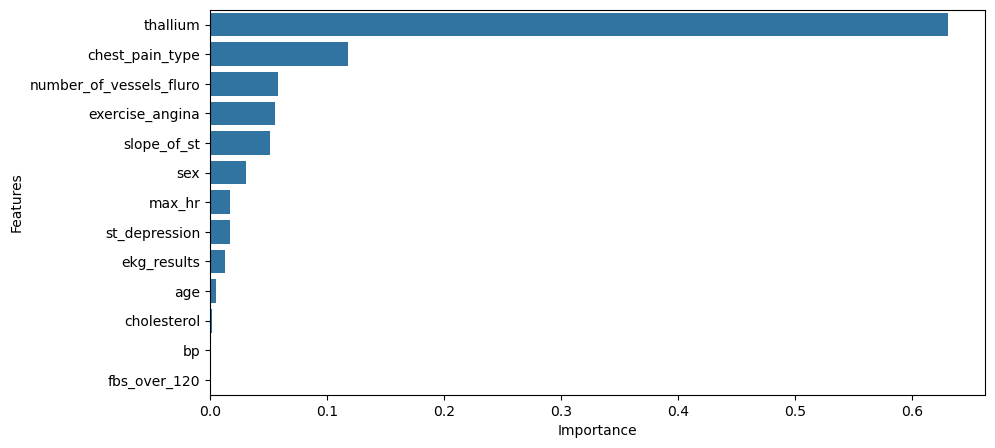

In [23]:
sns.barplot(data=importance_df.sort_values(by='Importance', ascending=False), y='Features', x='Importance')

## Run Predictions

In [24]:
final_preds = np.zeros(len(X_test))

final_preds = xgb_model.predict(X_test)

## Prepare Submission

In [25]:
# Create submission
submission_df = pd.DataFrame({
  'id': orig_test_df['id'],
  'Heart Disease': final_preds
})

In [26]:
last_submission = pd.read_csv(find_last_submission_file())

In [27]:
# submission_df.to_csv('./archive/submission_01.csv', index=False)

In [28]:
submission_df.head()

,id,Heart Disease
0,630000,1
1,630001,0
2,630002,1
3,630003,0
4,630004,0


In [29]:
submission_df['Heart Disease'].value_counts()

Heart Disease
0    150484
1    119516
Name: count, dtype: int64

In [30]:
if np.allclose(last_submission['Heart Disease'], submission_df['Heart Disease']):
    # they are the same, don't same
    print('skipping save')
else:
    submission_df.to_csv(find_next_submission_file(), index=False)
    print('saving file')

saving file
